In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import seaborn as sns
from datetime import *
from dateutil.relativedelta import relativedelta

from pypfopt.plotting import *
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt import expected_returns, EfficientSemivariance, EfficientCVaR, EfficientCDaR, HRPOpt, BlackLittermanModel, black_litterman

In [2]:
cutoff_date = date.today() - relativedelta(years = 2, weekday=1)

Downloading historical prices

In [3]:
tickers = ['XOM', 'MNST', 'PCG', 'TKO', 'DLTR', 'DVN', 'OXY', 'COP', 'EOG', 'CVX']
prices = yf.download(tickers, period = '10y' , progress = False)['Close'].dropna()
prices

YF.download() has changed argument auto_adjust default to True


Ticker,COP,CVX,DLTR,DVN,EOG,MNST,OXY,PCG,TKO,XOM
Date,,,,,,,,,,
2015-04-13,48.221874,69.409645,81.820000,45.067902,71.291183,22.963333,57.293983,48.045261,11.702909,55.120441
2015-04-14,49.690212,70.934692,81.050003,46.170532,72.752861,22.633333,58.443687,47.999374,11.625690,55.953613
2015-04-15,50.446171,71.957916,81.209999,46.721840,73.884224,22.948334,60.072453,47.650620,11.677173,56.890175
2015-04-16,50.162674,71.794991,81.029999,46.470608,73.914368,23.000000,59.969280,47.650620,12.054686,56.664120
2015-04-17,49.203194,71.110687,79.139999,46.003036,73.333641,22.818333,59.350174,48.054440,11.874506,56.147381
...,...,...,...,...,...,...,...,...,...,...
2025-04-07,85.669998,140.149994,72.839996,28.610001,109.029999,57.110001,38.750000,16.080000,141.179993,102.940002
2025-04-08,82.660004,136.929993,69.699997,26.799999,104.959999,55.009998,36.110001,15.940000,138.960007,100.769997
2025-04-09,91.510002,146.029999,72.570000,31.070000,114.050003,58.250000,40.230000,16.809999,148.539993,105.800003


In [4]:
prices_train = prices.loc[:cutoff_date]
prices_test = prices.loc[cutoff_date:]

In [5]:
returns_train = prices_train.pct_change(fill_method = None).dropna()
returns_train

Ticker,COP,CVX,DLTR,DVN,EOG,MNST,OXY,PCG,TKO,XOM
Date,,,,,,,,,,
2015-04-14,0.030450,0.021972,-0.009411,0.024466,0.020503,-0.014371,0.020067,-0.000955,-0.006598,0.015115
2015-04-15,0.015213,0.014425,0.001974,0.011941,0.015551,0.013918,0.027869,-0.007266,0.004428,0.016738
2015-04-16,-0.005620,-0.002264,-0.002216,-0.005377,0.000408,0.002251,-0.001717,0.000000,0.032329,-0.003974
2015-04-17,-0.019127,-0.009531,-0.023325,-0.010062,-0.007857,-0.007899,-0.010324,0.008475,-0.014947,-0.009119
2015-04-20,0.013591,0.010814,0.007202,0.011377,0.005245,0.019502,-0.001986,0.004202,0.013729,0.003566
...,...,...,...,...,...,...,...,...,...,...
2023-04-12,0.007307,0.003546,-0.018946,0.004420,0.005178,0.003634,0.007301,0.008323,-0.000875,-0.001040
2023-04-13,0.014043,0.013367,-0.008590,0.012468,-0.001605,0.007623,-0.001079,-0.009434,0.003600,0.004686
2023-04-14,-0.004952,0.002034,-0.006583,0.008693,0.002638,-0.005863,-0.004477,0.005357,0.014930,0.002419


<Axes: xlabel='Ticker', ylabel='Ticker'>

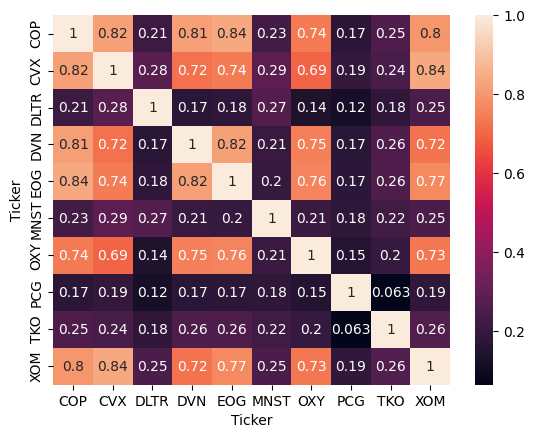

In [6]:
sns.heatmap(returns_train.corr(), annot = True)

In [7]:
spy_prices = yf.download('SPY', progress = False)['Close'].dropna()

mcaps = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_cap = stock.info.get("marketCap")
    mcaps[ticker] = market_cap
    
mcaps

{'XOM': 446110400512,
 'MNST': 56589197312,
 'PCG': 37184749568,
 'TKO': 11772291072,
 'DLTR': 15509636096,
 'DVN': 18308679680,
 'OXY': 36979470336,
 'COP': 109211648000,
 'EOG': 59864588288,
 'CVX': 236907642880}

Classic Mean-Variance

OrderedDict({'COP': 0.0, 'CVX': 0.1138319992898849, 'DLTR': 0.0131326955395802, 'DVN': 0.0, 'EOG': 0.0, 'MNST': 0.2381341962226282, 'OXY': 0.0, 'PCG': 0.0, 'TKO': 0.6349011089479066, 'XOM': 0.0})


<Axes: xlabel='Weight'>

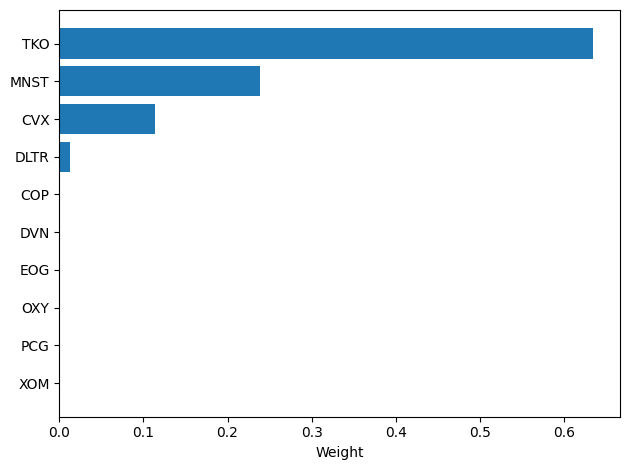

In [8]:
mu_classic = expected_returns.mean_historical_return(prices_train)
S_classic = sample_cov(prices_train)

ef_classic = EfficientFrontier(mu_classic, S_classic)
weights_classic = ef_classic.max_sharpe()
print(weights_classic)
plot_weights(weights_classic)

Robuse Mean-Variance (shrinkage)

<Axes: xlabel='Weight'>

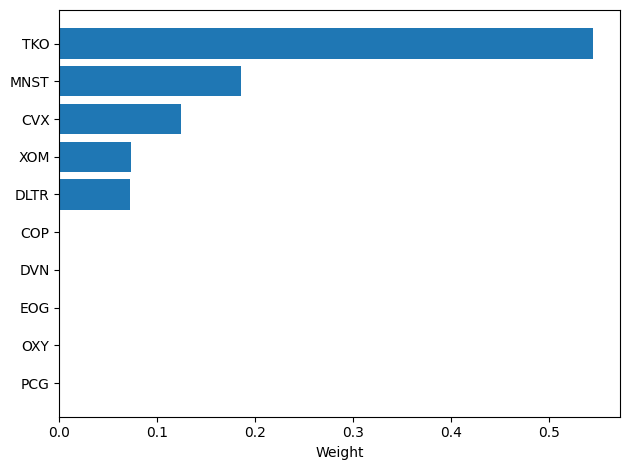

In [9]:
mu_shrink = expected_returns.mean_historical_return(prices_train)
S_shrink = CovarianceShrinkage(prices_train).shrunk_covariance(delta = 0.4)

ef_shrink = EfficientFrontier(mu_shrink, S_shrink)
weights_shrink = ef_shrink.max_sharpe()
plot_weights(weights_shrink)

Robust Mean-Variance (ledoit wolf)

<Axes: xlabel='Weight'>

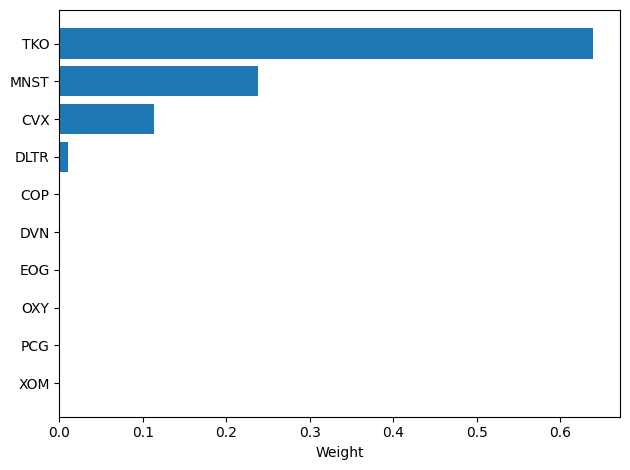

In [10]:
mu_ledoit = expected_returns.mean_historical_return(prices_train)
S_ledoit = CovarianceShrinkage(prices_train).ledoit_wolf('constant_correlation')

ef_ledoit = EfficientFrontier(mu_ledoit, S_ledoit)
weights_ledoit = ef_ledoit.max_sharpe()
plot_weights(weights_ledoit)

Efficient CVaR

In [11]:
mu_cvar = expected_returns.mean_historical_return(prices_train)
historical_returns_cvar = expected_returns.returns_from_prices(prices_train)

ef_cvar = EfficientCVaR(mu_cvar, historical_returns_cvar)
ef_cvar.min_cvar()

# We can use the same helper methods as before
weights_cvar = ef_cvar.clean_weights()
print(weights_cvar)
print(ef_cvar.portfolio_performance(verbose=True))

OrderedDict({'COP': 0.0, 'CVX': 0.08864, 'DLTR': 0.17598, 'DVN': 0.0, 'EOG': 0.0, 'MNST': 0.34449, 'OXY': 0.0, 'PCG': 0.01187, 'TKO': 0.11121, 'XOM': 0.26782})
Expected annual return: 11.8%
Conditional Value at Risk: 3.03%
(np.float64(0.11770730118747018), np.float64(0.030297214292218745))


Hierarchical risk parity

OrderedDict({'COP': np.float64(0.0651296390536041), 'CVX': np.float64(0.06779301467659979), 'DLTR': np.float64(0.17564518894233758), 'DVN': np.float64(0.035677836197932744), 'EOG': np.float64(0.06684457269404492), 'MNST': np.float64(0.22408701454450405), 'OXY': np.float64(0.06489534792137709), 'PCG': np.float64(0.05849526893355264), 'TKO': np.float64(0.16373377363865874), 'XOM': np.float64(0.07769834339738838)})
Expected annual return: 17.5%
Annual volatility: 23.2%
Sharpe Ratio: 0.75


<Axes: >

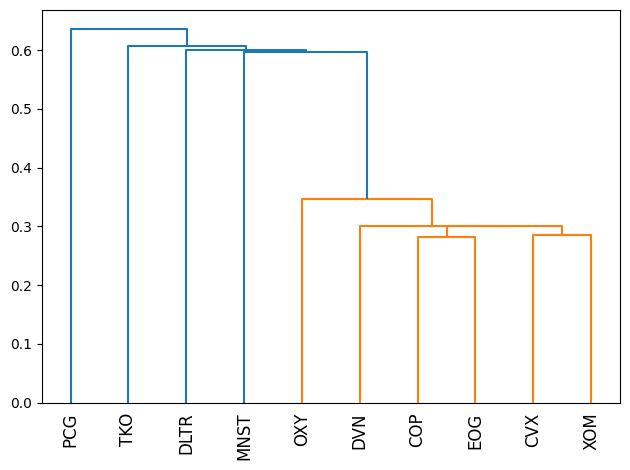

In [12]:
hrp = HRPOpt(returns_train)
weights_hrp = hrp.optimize()
print(weights_hrp)
hrp.portfolio_performance(verbose=True)
plot_dendrogram(hrp)

Black-Litterman model

In [13]:
mu_bl = expected_returns.mean_historical_return(prices_train)
S_bl = sample_cov(prices_train)
delta = black_litterman.market_implied_risk_aversion(spy_prices)
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S_bl)

In [14]:
[0] * len(tickers)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
returns_train.columns

Index(['COP', 'CVX', 'DLTR', 'DVN', 'EOG', 'MNST', 'OXY', 'PCG', 'TKO', 'XOM'], dtype='object', name='Ticker')

In [16]:
views = np.array([0.4204, 0.1986, 0.2994, 0.4005, 0.1616, 0.1247, 0.0039, 0.1281, 0.2592, 0.0505]).reshape(-1, 1)
picking = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    ]
)

bl = BlackLittermanModel(S_bl, Q=views, P=picking, pi=prior, tau=0.02)
rets_bl = bl.bl_returns()
ef_bl = EfficientFrontier(rets_bl, S_bl)
weights_bl = ef_bl.max_sharpe()
print(ef_bl.clean_weights())
ef_bl.portfolio_performance(verbose=True)

OrderedDict({'COP': 0.26698, 'CVX': 0.12475, 'DLTR': 0.29865, 'DVN': 0.00964, 'EOG': 0.0, 'MNST': 0.10636, 'OXY': 0.0, 'PCG': 0.02246, 'TKO': 0.17116, 'XOM': 0.0})
Expected annual return: 20.4%
Annual volatility: 24.3%
Sharpe Ratio: 0.84


(np.float64(0.20354671961107296),
 np.float64(0.24272020559378238),
 np.float64(0.8386064073780889))

<Axes: xlabel='Weight'>

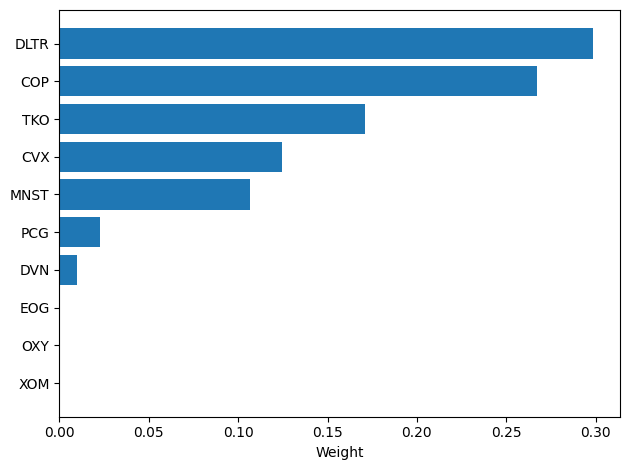

In [17]:
plot_weights(weights_bl)

In [18]:
in_sample = {
    'MV': sum(returns_train[ticker] * weights_classic[ticker] for ticker in prices.columns),
    'Ledoit': sum(returns_train[ticker] * weights_ledoit[ticker] for ticker in prices.columns),
    'Shrunk (d = 0.4)': sum(returns_train[ticker] * weights_shrink[ticker] for ticker in prices.columns),
    'Mean-CVaR': sum(returns_train[ticker] * weights_cvar[ticker] for ticker in prices.columns),
    'Black-Litterman': sum(returns_train[ticker] * weights_bl[ticker] for ticker in prices.columns),
    'HRP': sum(returns_train[ticker] * weights_hrp[ticker] for ticker in prices.columns)
}

in_sample_returns = pd.DataFrame(in_sample)
in_sample_cumulative_returns = (1 + in_sample_returns).cumprod()
in_sample_cumulative_returns_max = in_sample_cumulative_returns.cummax()
in_sample_drawdowns = (in_sample_cumulative_returns - in_sample_cumulative_returns_max)/in_sample_cumulative_returns_max

px.line(in_sample_cumulative_returns)

In [19]:
px.line(in_sample_drawdowns, title = 'Drawdowns')

In [20]:
in_sample_returns.std().sort_values().map('{:.3%}'.format)

Mean-CVaR           1.308%
HRP                 1.459%
Black-Litterman     1.529%
Shrunk (d = 0.4)    1.642%
MV                  1.784%
Ledoit              1.792%
dtype: object

In [21]:
in_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

Ledoit              -53.989%
MV                  -53.820%
Shrunk (d = 0.4)    -53.233%
Black-Litterman     -50.047%
HRP                 -49.664%
Mean-CVaR           -39.694%
dtype: object

In [22]:
in_sample_cagr = (1 + in_sample_returns).prod() ** (252 / len(in_sample_returns)) - 1
in_sample_cagr.sort_values().map('{:.2%}'.format)

Mean-CVaR           14.84%
HRP                 15.89%
Black-Litterman     16.62%
Shrunk (d = 0.4)    24.42%
MV                  26.12%
Ledoit              26.19%
dtype: object

In [23]:
weights = {
    'MV': weights_classic,
    'Ledoit (constant correlation)': weights_ledoit,
    'Shrunk (d = 0.4)': weights_shrink,
    'Mean-CVaR': weights_cvar,
    'Black-Litterman': weights_bl,
    'HRP': weights_hrp
}

weights = pd.DataFrame(weights)
weights_long = weights.T.reset_index().melt(id_vars='index', var_name='Stock Ticker', value_name='Weight')

fig = px.bar(weights_long, 
             x='index', 
             y='Weight', 
             color='Stock Ticker', 
             barmode='stack',
             title='Stacked Portfolio Weights by Optimization Method',
             labels={'index': 'Optimization Method', 'Weight': 'Portfolio Weight', 'Stock Ticker': 'Stock'},
             text='Weight'
             )

fig.update_traces(texttemplate='%{text:.1%}', textposition='inside')
fig.show()

In [24]:
returns_test = prices_test.pct_change(fill_method=None).dropna()
returns_test

Ticker,COP,CVX,DLTR,DVN,EOG,MNST,OXY,PCG,TKO,XOM
Date,,,,,,,,,,
2023-04-19,0.002954,0.000938,-0.005958,-0.006700,-0.001680,-0.003607,-0.008413,-0.000592,0.002177,-0.003164
2023-04-20,-0.014060,-0.004863,0.009159,-0.015132,-0.004546,0.007811,-0.007043,0.001184,0.003022,-0.007978
2023-04-21,-0.014646,-0.004298,0.007608,-0.007220,-0.008033,0.003214,-0.002579,-0.001183,0.029661,0.003200
2023-04-24,0.013593,0.013955,0.016359,0.015663,0.015941,0.011871,0.014385,0.014802,-0.001646,0.018878
2023-04-25,-0.015051,-0.014521,-0.007168,-0.023132,-0.021061,0.009497,-0.022785,0.007585,-0.008885,-0.014213
...,...,...,...,...,...,...,...,...,...,...
2025-04-07,-0.007185,-0.021845,0.078312,-0.023883,-0.013749,0.000526,-0.044154,-0.021898,0.011463,-0.013418
2025-04-08,-0.035135,-0.022975,-0.043108,-0.063265,-0.037329,-0.036771,-0.068129,-0.008706,-0.015725,-0.021080
2025-04-09,0.107065,0.066457,0.041177,0.159328,0.086604,0.058898,0.114096,0.054580,0.068941,0.049916


In [25]:
out_of_sample = {
    'MV': sum(returns_test[ticker] * weights_classic[ticker] for ticker in prices.columns),
    'Ledoit': sum(returns_test[ticker] * weights_ledoit[ticker] for ticker in prices.columns),
    'Shrunk (d = 0.4)': sum(returns_test[ticker] * weights_shrink[ticker] for ticker in prices.columns),
    'Mean-CVaR': sum(returns_test[ticker] * weights_cvar[ticker] for ticker in prices.columns),
    'Black-Litterman': sum(returns_test[ticker] * weights_bl[ticker] for ticker in prices.columns),
    'HRP': sum(returns_test[ticker] * weights_hrp[ticker] for ticker in prices.columns)
}

out_of_sample_returns = pd.DataFrame(out_of_sample)
out_of_sample_cumulative_returns = (1 + out_of_sample_returns).cumprod()
out_of_sample_cumulative_returns_max = out_of_sample_cumulative_returns.cummax()
out_of_sample_drawdowns = (out_of_sample_cumulative_returns - out_of_sample_cumulative_returns_max)/out_of_sample_cumulative_returns_max

px.line(out_of_sample_cumulative_returns)

In [26]:
out_of_sample_returns.std().sort_values().map('{:.3%}'.format)

Mean-CVaR           1.026%
HRP                 1.053%
Black-Litterman     1.234%
Shrunk (d = 0.4)    1.348%
MV                  1.484%
Ledoit              1.492%
dtype: object

In [27]:
out_of_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

Ledoit              -25.176%
MV                  -25.027%
Shrunk (d = 0.4)    -22.580%
Black-Litterman     -22.216%
Mean-CVaR           -15.395%
HRP                 -15.206%
dtype: object

In [28]:
out_of_sample_cagr = (1 + out_of_sample_returns).prod() ** (252 / len(out_of_sample_returns)) - 1
out_of_sample_cagr.sort_values().map('{:.2%}'.format)

Black-Litterman     -6.72%
HRP                 -3.06%
Mean-CVaR           -1.42%
Shrunk (d = 0.4)    10.01%
MV                  14.26%
Ledoit              14.46%
dtype: object